In [1]:
#Loading libraries

#Pytorch, plotting
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import Tensor
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Subset
from torchvision import models

#General/other
from typing import Set, Tuple, List
import numpy as np
import random, time
from pathlib import Path
import os, math

#Loading functions

from tools import augment_training, plot_training_curve, get_model_name, get_correct, get_model_path, evaluate, seed_worker, load_randomized_loaders
from tools import save_features, train_classifier, genre_classifier, plot_confusion_matrix

#NOTE: In order to import 'tools', you need to add ./__Main__ to your PYTHONPATH env variables (otherwise you will get an import error).

In [2]:
#Splitting into training, validation and testing datasets. Can provide randomizing seed, to help replicate results.

spectrograms_path: str = r'W:\school\aps360\APS360-Music-Genre-Classifier\Dataset\youtube_spectrograms'

classification_dict: dict[int, str] = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

Importing ResNet

In [3]:
#Importing resnet, and modifying classifier.
resnet152 = models.resnet152(pretrained=True)

#Since resnet does not have 'features', we need to manually remove the last fc layer.
modules = list(resnet152.children())[:-1] # delete the last fc layer.
resnet152 = nn.Sequential(*modules)

#Also need to remove grads from params, as we are no longer training the weights for the encoder
# for param in resnet152.parameters():
#     param.requires_grad = False

c:\Users\Durango\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Durango\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now, creating feature loaders.

In [4]:
#Saving features for loaders

#Creating new loaders with batch size of 256

train_loader, validation_loader, test_loader = load_randomized_loaders(spectrograms_path, batch_size=256, augment=False)


train_resnet: List[Tuple[Tensor, Tensor]] = save_features(train_loader, resnet152)
val_resnet: List[Tuple[Tensor, Tensor]] = save_features(validation_loader, resnet152)
test_resnet: List[Tuple[Tensor, Tensor]] = save_features(test_loader, resnet152)

In [5]:
for features, labels in train_resnet:
    print(features.shape)
    print(labels.shape)
    break

#NOTE that resent152 used a global average pooling operation right before its fully connected layer. This explains why the final dimension is 1x1

torch.Size([256, 2048, 1, 1])
torch.Size([256])


In [7]:
classifier = genre_classifier(dropout_prob= 0.4, output_size= 1 * 1 * 2048, first_fc_dim=1024, second_fc_dim=512)
gpu: bool = True

if torch.cuda.is_available and gpu:
    classifier = classifier.cuda()

train_classifier(train_resnet, val_resnet, net=classifier, use_gpu=gpu, learning_rate=0.1*3*math.e**(-4), num_epochs=250, batch_size=256)

Training on GPU 'NVIDIA GeForce RTX 2080 Ti'
Batch size: 256	Learning rate: 0.005494691666620257	Epochs: 250
Using dropout: 0.4
Weight decay: 0.0005
Epoch 1: Train acc: 0.09734513274336283, Train loss: 2.3116425275802612 |Validation acc: 0.1592920353982301, Validation loss: 2.288898229598999
Epoch 2: Train acc: 0.11283185840707964, Train loss: 2.30082768201828 |Validation acc: 0.1415929203539823, Validation loss: 2.2879080772399902
Epoch 3: Train acc: 0.15486725663716813, Train loss: 2.290236175060272 |Validation acc: 0.11504424778761062, Validation loss: 2.2963051795959473
Epoch 4: Train acc: 0.1592920353982301, Train loss: 2.280048906803131 |Validation acc: 0.1592920353982301, Validation loss: 2.272453546524048
Epoch 5: Train acc: 0.18694690265486727, Train loss: 2.268513560295105 |Validation acc: 0.17699115044247787, Validation loss: 2.2590672969818115
Epoch 6: Train acc: 0.21460176991150443, Train loss: 2.253587782382965 |Validation acc: 0.19469026548672566, Validation loss: 2.2603

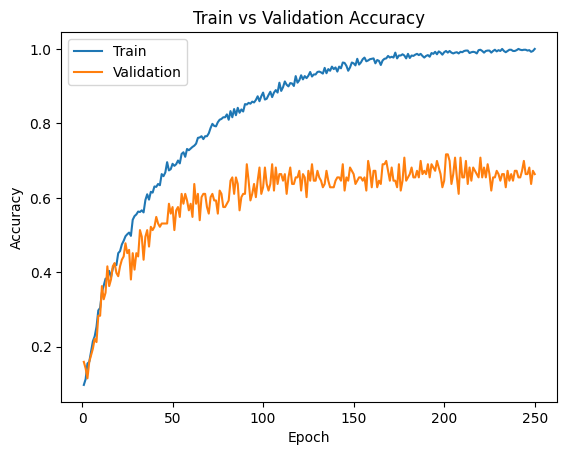

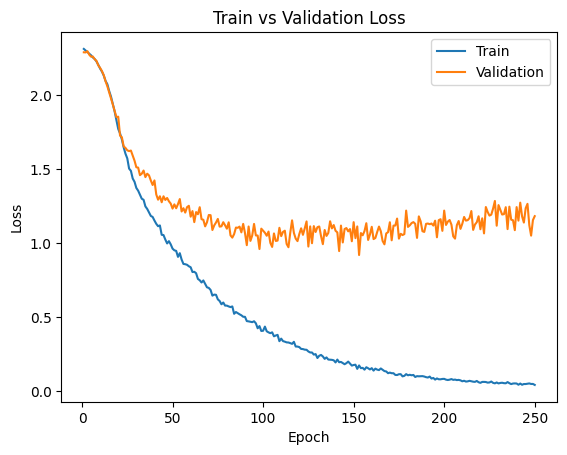

In [8]:
#Plotting results

model_path = get_model_path(model = classifier, lr = 0.1*3*math.e**(-4), batch_size = 256, epoch = 250)
plot_training_curve(model_path)

In [ ]:
#Loading best model
best_classifier = genre_classifier(dropout_prob=0.5, output_size= 2048 * 1 * 1, first_fc_dim=1024, second_fc_dim=512)

if torch.cuda.is_available:
    best_classifier = best_classifier.cuda()

model_path = get_model_path(best_classifier, 0.1*3*math.e**(-4), batch_size=256, epoch=200, at_epoch=70) #epoch 70 had the best validation accuracy
state = torch.load(model_path)
best_classifier.load_state_dict(state)

C:\Users\Durango\AppData\Local\Temp\ipykernel_14628\3152878862.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
#Testing best model

test_acc, test_loss = evaluate(best_classifier, test_resnet, criterion=nn.CrossEntropyLoss(), use_gpu=True)

print(f"Test accuracy: {test_acc}\nTest loss: {test_loss}")

Test accuracy: 0.5539143279172821
Test loss: 1.3095976114273071


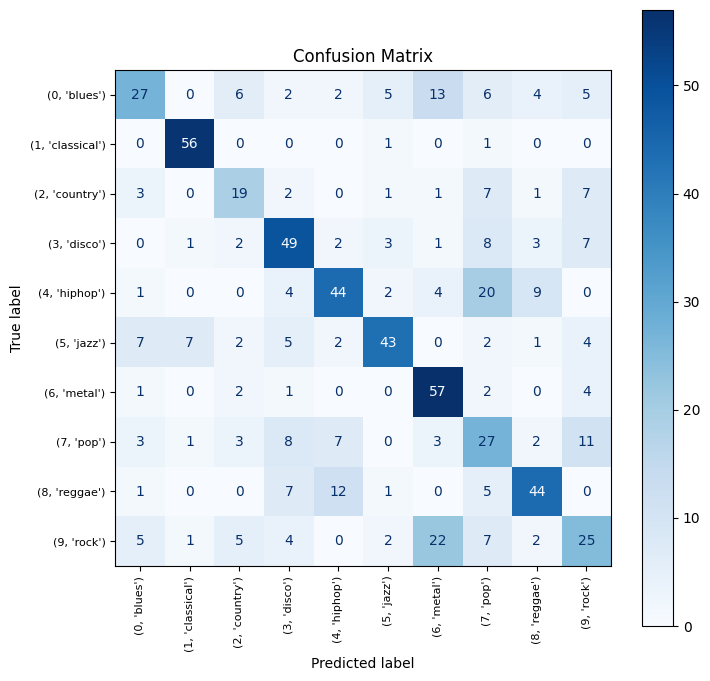

In [23]:
plot_confusion_matrix(best_classifier, test_resnet, classification_dict.items())